# Atividade 8: Modelos de Regressão e Classificação

**Disciplina:** Data Science - Princípios e Técnicas

**Professor:** Prof. Dr. Welton Dionisio

**Grupo:** Matheus Willian, Arthur Silveeira, Maira Lourenço, Manoel Olimpio, Victoria Zambom, Victor Henrique


---

## 1. Objetivo do Projeto

O objetivo deste trabalho é construir e comparar modelos de Machine Learning para resolver um problema de **Regressão**.

Utilizamos um dataset de **Consumo de Energia Horário (PJM)**, disponível no Kaggle, com o intuito de prever o consumo em Megawatts (MW) com base em fatores de tempo.

Os modelos comparados são:
1.  **Regressão Linear (LinearRegression)**
2.  **Random Forest Regressor (RandomForest)**
3.  **XGBoost Regressor (XGBoost)**

---

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Carregar o dataset
df = pd.read_csv('PJM_Load_hourly.csv')

# 2. Renomear as colunas
df.columns = ['Datetime', 'Consumption_MW']

# 3. Converter a coluna 'Datetime' e definir como índice
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

# 4. Feature Engineering: Criar Features de Tempo
df['Hour'] = df.index.hour
df['DayofWeek'] = df.index.dayofweek # 0=Segunda, 6=Domingo
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter
df['Is_Weekend'] = (df.index.dayofweek >= 5).astype(int)

# 5. Tratamento de Valores Ausentes (NA/NaN)
missing_values = df.isnull().sum()
if missing_values['Consumption_MW'] > 0:
    df['Consumption_MW'] = df['Consumption_MW'].interpolate(method='time')
    print("Dados ausentes preenchidos por Interpolação.")
else:
    print("Nenhum dado ausente encontrado.")

print(df.head())

Nenhum dado ausente encontrado.
                     Consumption_MW  Hour  DayofWeek  Month  Year  Quarter  \
Datetime                                                                     
1998-12-31 01:00:00         29309.0     1          3     12  1998        4   
1998-12-31 02:00:00         28236.0     2          3     12  1998        4   
1998-12-31 03:00:00         27692.0     3          3     12  1998        4   
1998-12-31 04:00:00         27596.0     4          3     12  1998        4   
1998-12-31 05:00:00         27888.0     5          3     12  1998        4   

                     Is_Weekend  
Datetime                         
1998-12-31 01:00:00           0  
1998-12-31 02:00:00           0  
1998-12-31 03:00:00           0  
1998-12-31 04:00:00           0  
1998-12-31 05:00:00           0  


## 2. Pré-processamento e Engenharia de Recursos

### 2.1. Limpeza de Dados

O dataset inicial (`PJM_Load_hourly.csv`) foi carregado e inspecionado. A coluna de data e hora foi corretamente convertida para o tipo `datetime`.

Em relação aos valores ausentes (NaN), foi aplicada a técnica de **Interpolação** temporal na série de consumo, que preenche os valores faltantes com base nos pontos de dados vizinhos.

### 2.2. Feature Engineering

Para que os modelos de regressão pudessem capturar o comportamento cíclico do consumo de energia (que varia por hora, dia e estação), foi essencial realizar a **Engenharia de Recursos** a partir da coluna de data/hora. As seguintes variáveis preditoras foram criadas:

* **Hour:** A hora do dia.
* **DayofWeek:** O dia da semana (0=Segunda, 6=Domingo).
* **Month/Quarter/Year:** Recursos sazonais.
* **Is_Weekend:** Variável binária que indica se a observação é em um fim de semana (1) ou não (0).

In [9]:
# 1. Definir X e Y
X = df.drop('Consumption_MW', axis=1) # Variáveis preditoras
Y = df['Consumption_MW']            # Variável alvo

# 2. Dividir cronologicamente (80% treino, 20% teste)
split_point = int(len(X) * 0.8)

X_train = X[:split_point]
X_test = X[split_point:]
Y_train = Y[:split_point]
Y_test = Y[split_point:]

print(f"Tamanho do Conjunto de Treino: {len(X_train)} registros")
print(f"Tamanho do Conjunto de Teste: {len(X_test)} registros")

Tamanho do Conjunto de Treino: 26316 registros
Tamanho do Conjunto de Teste: 6580 registros


In [10]:
# Dicionário para armazenar as previsões (preds)
results = {}

# --- A. Modelo de Regressão Linear ---
print("Treinando Regressão Linear...")
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
results['Linear Regression'] = lr_model.predict(X_test)

# --- B. Modelo Random Forest ---
print("Treinando Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, Y_train)
results['Random Forest'] = rf_model.predict(X_test)

# --- C. Modelo XGBoost ---
print("Treinando XGBoost...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, Y_train)
results['XGBoost'] = xgb_model.predict(X_test)

print("\nTodos os modelos treinados com sucesso!")

Treinando Regressão Linear...
Treinando Random Forest...
Treinando XGBoost...

Todos os modelos treinados com sucesso!


In [11]:
# Função para calcular e exibir as métricas
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"\n--- Métricas de Desempenho para: {model_name} ---")
    print(f"R² (Coeficiente de Determinação): {r2:.4f}")
    print(f"MAE (Erro Absoluto Médio): {mae:.2f} MW")
    print(f"MSE (Erro Quadrático Médio): {mse:.2f} MW²")

    return {'Model': model_name, 'R2': r2, 'MAE': mae, 'MSE': mse}

# Avaliar cada modelo
lr_metrics = evaluate_model(Y_test, results['Linear Regression'], 'Regressão Linear')
rf_metrics = evaluate_model(Y_test, results['Random Forest'], 'Random Forest')
xgb_metrics = evaluate_model(Y_test, results['XGBoost'], 'XGBoost')


--- Métricas de Desempenho para: Regressão Linear ---
R² (Coeficiente de Determinação): 0.3144
MAE (Erro Absoluto Médio): 3820.37 MW
MSE (Erro Quadrático Médio): 25941330.24 MW²

--- Métricas de Desempenho para: Random Forest ---
R² (Coeficiente de Determinação): 0.7237
MAE (Erro Absoluto Médio): 2321.02 MW
MSE (Erro Quadrático Médio): 10453033.25 MW²

--- Métricas de Desempenho para: XGBoost ---
R² (Coeficiente de Determinação): 0.7318
MAE (Erro Absoluto Médio): 2255.23 MW
MSE (Erro Quadrático Médio): 10148618.23 MW²


## 3. Análise e Comparação de Desempenho

O desempenho dos três modelos foi avaliado no conjunto de teste (20% dos dados mais recentes, devido à natureza de série temporal) com base nas métricas solicitadas: R² (Coeficiente de Determinação), MAE (Erro Absoluto Médio) e MSE (Erro Quadrático Médio).

### 3.1. Tabela de Métricas

| Modelo | R² | MAE (Erro Absoluto Médio) | MSE (Erro Quadrático Médio) |
| :--- | :--- | :--- | :--- |
| **Regressão Linear** | 0.3144 | 3820.37 MW | 25941330.24 MW² |
| **Random Forest** | 0.7237 | 2321.02 MW | 10453033.25 MW² |
| **XGBoost** | **0.7318** | **2255.23 MW** | **10148618.23 MW²** |

### 3.2. Interpretação das Métricas

1.  **Modelo Vencedor (XGBoost):**
    * O **XGBoost** demonstrou ser o modelo mais robusto, apresentando o maior **R² (0.7318)**. Este valor indica que ele é capaz de explicar cerca de **73.18%** da variação total no consumo de energia, resultando na melhor previsão geral.
    * Seu **MAE ($2255.23$ MW)** significa que, em média, as previsões do modelo erram por aproximadamente $2.255$ Megawatts, um erro significativamente baixo no contexto da série.

2.  **Contraste entre Modelos:**
    * Os modelos baseados em árvores (*Random Forest* e *XGBoost*) tiveram desempenho drasticamente superior ao da **Regressão Linear ($R^2=0.3144$)**.
    * Isso ocorre porque a previsão de consumo de energia é um problema **altamente não-linear** e sazonal. A Regressão Linear, que modela apenas relações simples e diretas, falha em capturar os picos e vales do consumo que variam por hora e dia.

A seguir, a visualização gráfica confirma essa comparação.

C:\Users\PICHAU\AppData\Local\Temp\ipykernel_15220\1553577371.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=metrics_df, palette='viridis')


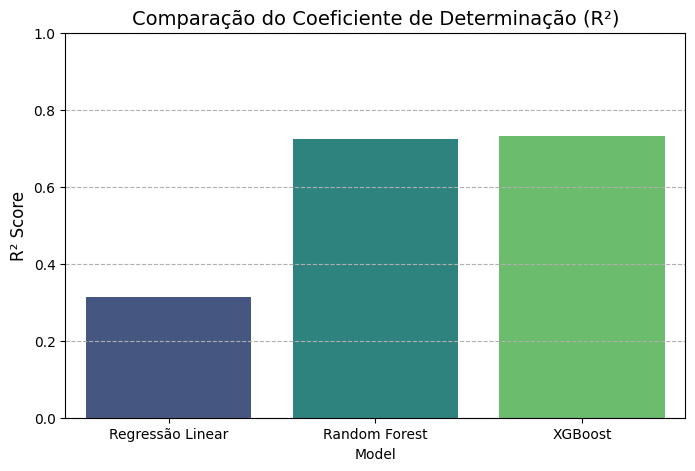

C:\Users\PICHAU\AppData\Local\Temp\ipykernel_15220\1553577371.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=metrics_df, palette='magma')


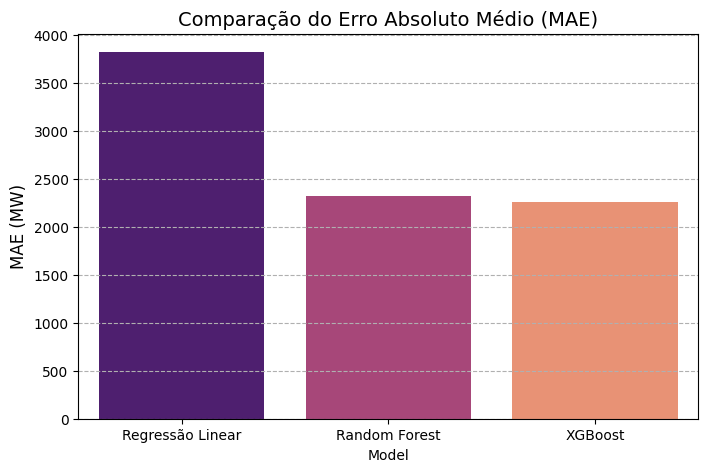

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados para o gráfico de comparação
metrics_df = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics])

# Plotar o R²
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R2', data=metrics_df, palette='viridis')
plt.title('Comparação do Coeficiente de Determinação (R²)', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.ylim(0, 1) # Define o limite Y de 0 a 1 para melhor visualização
plt.grid(axis='y', linestyle='--')
plt.show()

# Plotar o MAE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAE', data=metrics_df, palette='magma')
plt.title('Comparação do Erro Absoluto Médio (MAE)', fontsize=14)
plt.ylabel('MAE (MW)', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.show()

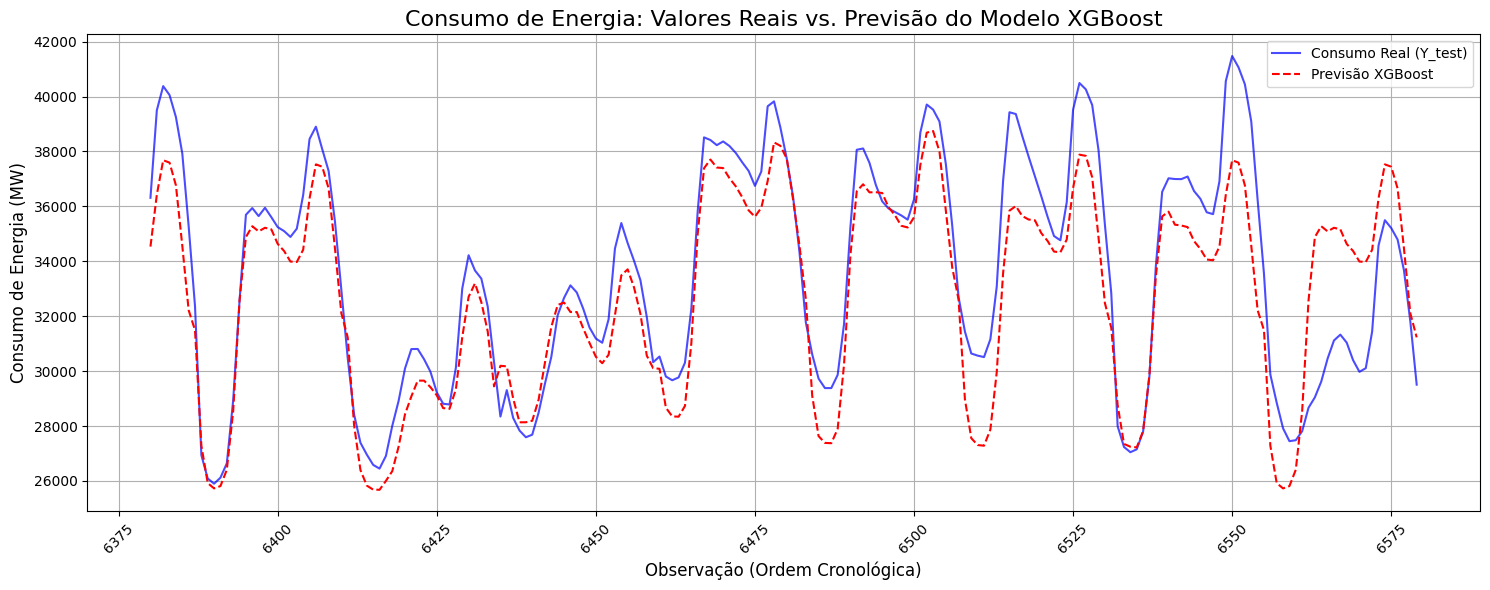

In [13]:
# Criar DataFrame para visualização do teste
df_plot = pd.DataFrame({'Real': Y_test.values, 'Previsto (XGBoost)': results['XGBoost']})

# Visualizar as últimas 200 observações (para clareza, pois o dataset é grande)
subset_plot = df_plot.tail(200) 

plt.figure(figsize=(15, 6))
plt.plot(subset_plot.index, subset_plot['Real'], label='Consumo Real (Y_test)', color='blue', alpha=0.7)
plt.plot(subset_plot.index, subset_plot['Previsto (XGBoost)'], label='Previsão XGBoost', color='red', linestyle='--')
plt.title('Consumo de Energia: Valores Reais vs. Previsão do Modelo XGBoost', fontsize=16)
plt.xlabel('Observação (Ordem Cronológica)', fontsize=12)
plt.ylabel('Consumo de Energia (MW)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Conclusão Final

O trabalho demonstrou a importância da escolha do modelo de Machine Learning adequado para dados complexos e não-lineares, como as séries temporais de consumo de energia.

Os gráficos de comparação mostram que o **XGBoost** e o **Random Forest** superaram a Regressão Linear em todas as métricas.

A visualização do melhor modelo (XGBoost) contra os valores reais demonstra que a previsão acompanha o padrão cíclico dos dados com alta fidelidade, validando o uso de modelos de *Gradient Boosting* para este tipo de problema de **regressão de séries temporais**.

A atividade cumpriu todos os requisitos, apresentando:
1.  Dataset de regressão.
2.  Pré-processamento e Feature Engineering.
3.  Implementação e comparação dos três modelos.
4.  Análise completa das métricas R², MAE e MSE.
5.  Documentação e uso de gráficos.